In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import json
import subprocess
from scipy.misc import imread
%matplotlib inline

from train import build_forward
from utils import googlenet_load, train_utils
from utils.annolist import AnnotationLib as al
from utils.stitch_wrapper import stitch_rects
from utils.train_utils import add_rectangles
from utils.rect import Rect
from utils.stitch_wrapper import stitch_rects
from evaluate import add_rectangles

In [2]:
hypes_file = './hypes/overfeat_rezoom.json'
iteration = 150000
with open(hypes_file, 'r') as f:
    H = json.load(f)
true_idl = './data/brainwash/brainwash_val.idl'
pred_idl = './output/%d_val_%s.idl' % (iteration, os.path.basename(hypes_file).replace('.json', ''))
true_annos = al.parse(true_idl)

0
10
20
30
40
50
60
70
80
90
2.240400 images/sec


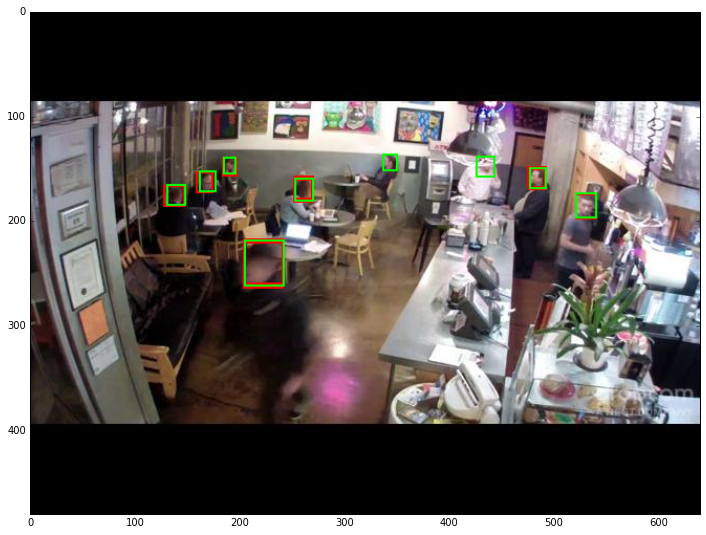

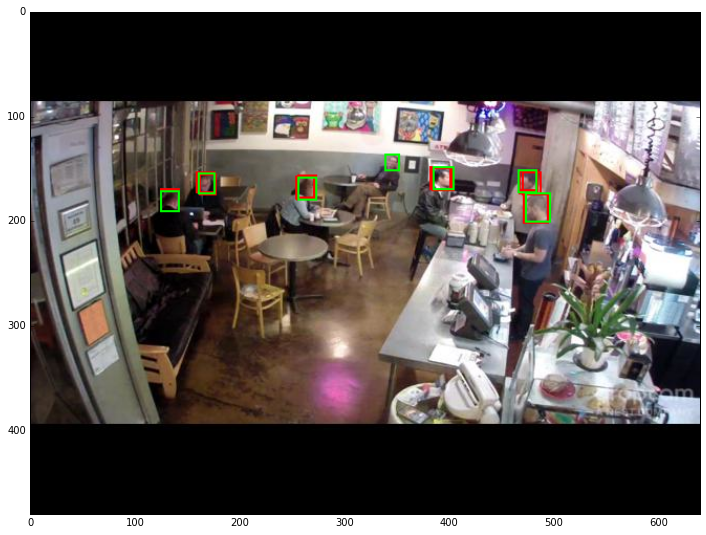

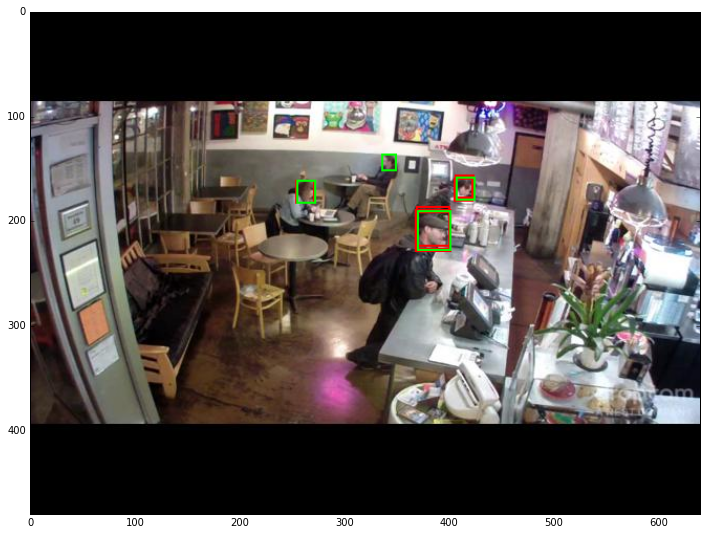

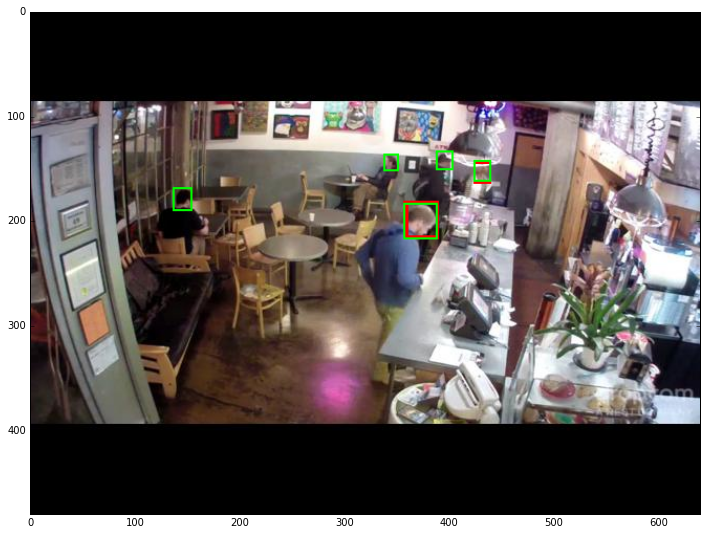

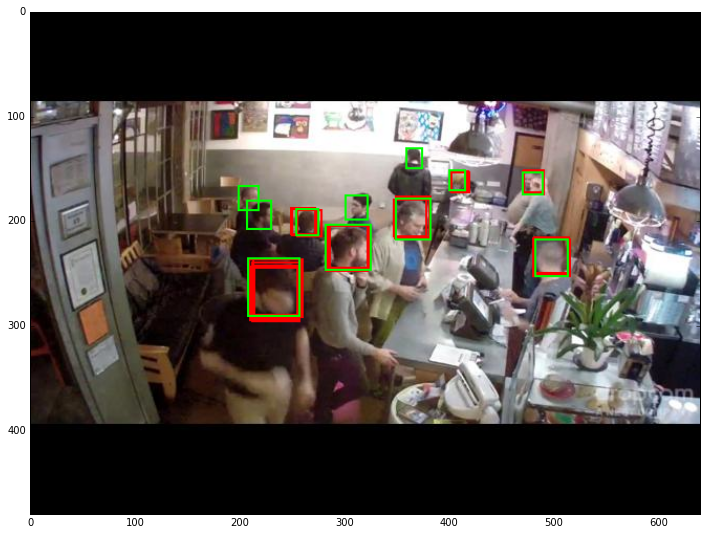

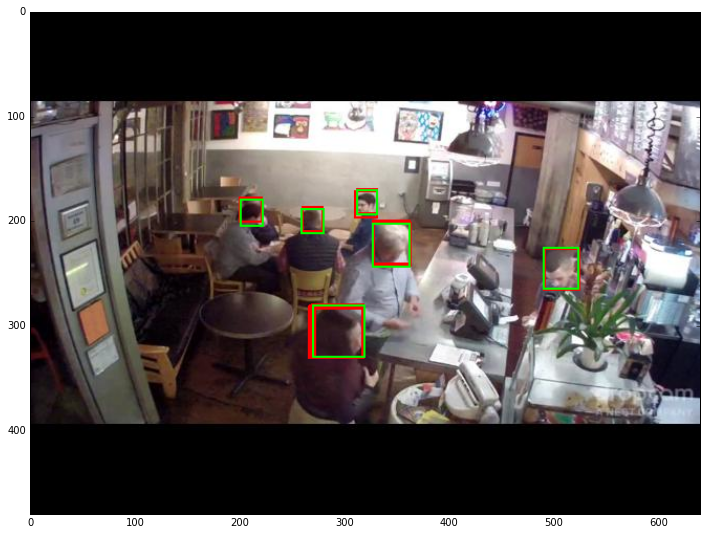

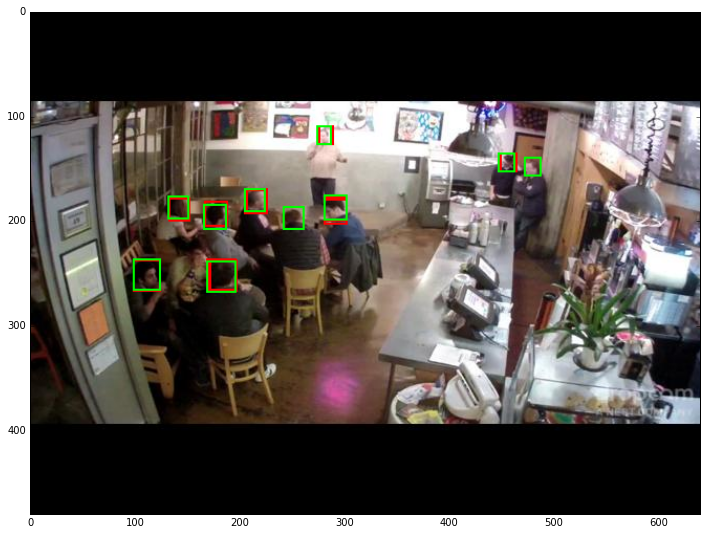

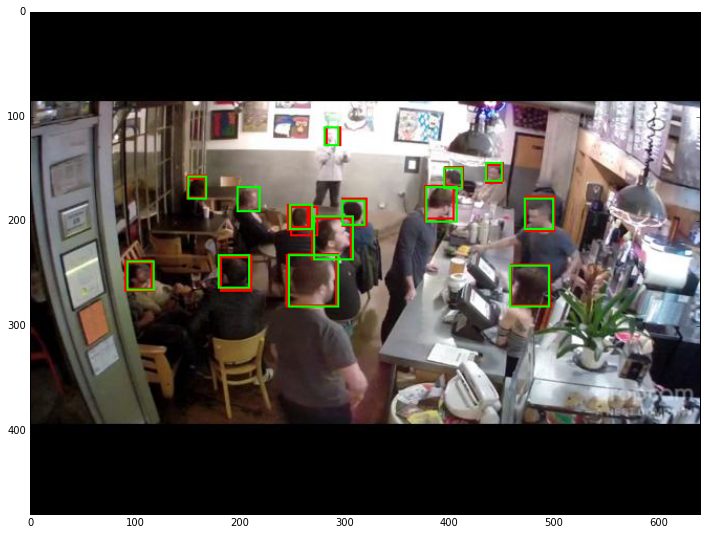

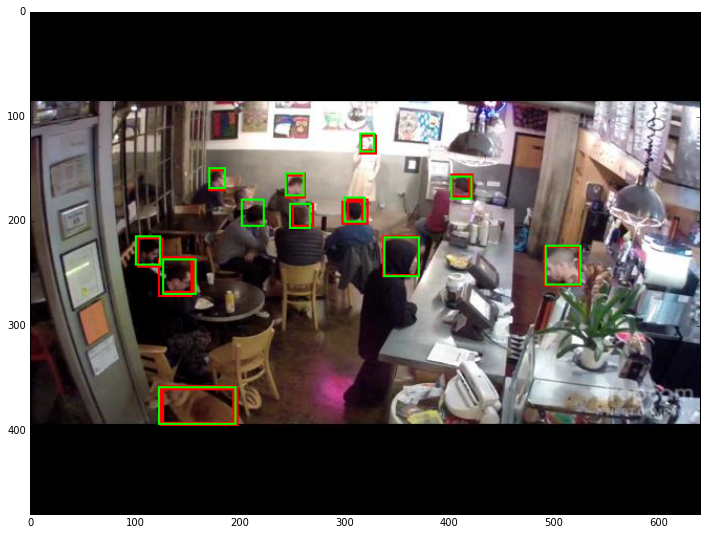

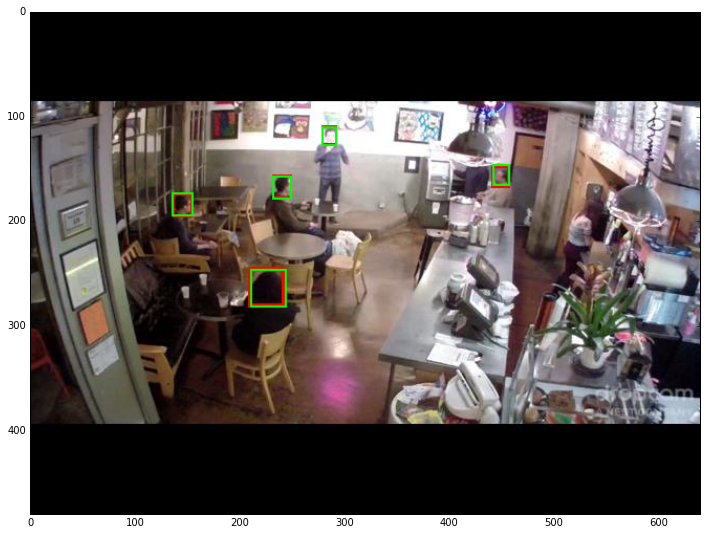

In [3]:
tf.reset_default_graph()
googlenet = googlenet_load.init(H)
x_in = tf.placeholder(tf.float32, name='x_in', shape=[H['image_height'], H['image_width'], 3])
if H['use_rezoom']:
    pred_boxes, pred_logits, pred_confidences, pred_confs_deltas, pred_boxes_deltas = build_forward(H, tf.expand_dims(x_in, 0), googlenet, 'test', reuse=None)
    grid_area = H['grid_height'] * H['grid_width']
    pred_confidences = tf.reshape(tf.nn.softmax(tf.reshape(pred_confs_deltas, [grid_area * H['rnn_len'], 2])), [grid_area, H['rnn_len'], 2])
    if H['reregress']:
        pred_boxes = pred_boxes + pred_boxes_deltas
else:
    pred_boxes, pred_logits, pred_confidences = build_forward(H, tf.expand_dims(x_in, 0), googlenet, 'test', reuse=None)
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    saver.restore(sess, './data/overfeat_rezoom/save.ckpt-%d' % iteration)

    annolist = al.AnnoList()
    import time; t = time.time()
    for i in range(0, 500):
        true_anno = true_annos[i]
        img = imread('./data/brainwash/%s' % true_anno.imageName)
        feed = {x_in: img}
        (np_pred_boxes, np_pred_confidences) = sess.run([pred_boxes, pred_confidences], feed_dict=feed)
        pred_anno = al.Annotation()
        pred_anno.imageName = true_anno.imageName
        new_img, rects = add_rectangles(H, [img], np_pred_confidences, np_pred_boxes,
                                        use_stitching=True, rnn_len=H['rnn_len'], min_conf=0.3)
    
        pred_anno.rects = rects
        annolist.append(pred_anno)

        if i % 10 == 0 and i < 200:
            pass
            fig = plt.figure(figsize=(12, 12))
            plt.imshow(new_img)
        if i % 100 == 0:
            print(i)
    avg_time = (time.time() - t) / (i + 1)
    print('%f images/sec' % (1. / avg_time))

saving:  ./output/150000_val_overfeat_rezoom.idl
$ ./utils/annolist/doRPC.py --minOverlap 0.500000 ./data/brainwash/brainwash_val.idl ./output/150000_val_overfeat_rezoom.idl
Minimum width: 0 height: 0
Asorting too large/ too small detections
minWidth: 0
minHeight: 0
maxWidth:  inf
maxHeight:  inf
#Annotations: 912
Setting up graphs ...
No annotation/detection pair found for: brainwash_11_24_2014_images/07019000_640x480.png frame: -1
No annotation/detection pair found for: brainwash_11_24_2014_images/07019500_640x480.png frame: -1
No annotation/detection pair found for: brainwash_11_24_2014_images/07020000_640x480.png frame: -1
No annotation/detection pair found for: brainwash_11_24_2014_images/07020500_640x480.png frame: -1
No annotation/detection pair found for: brainwash_11_24_2014_images/07021000_640x480.png frame: -1
No annotation/detection pair found for: brainwash_11_24_2014_images/07021500_640x480.png frame: -1
No annotation/detection pair found for: brainwash_11_24_2014_images/

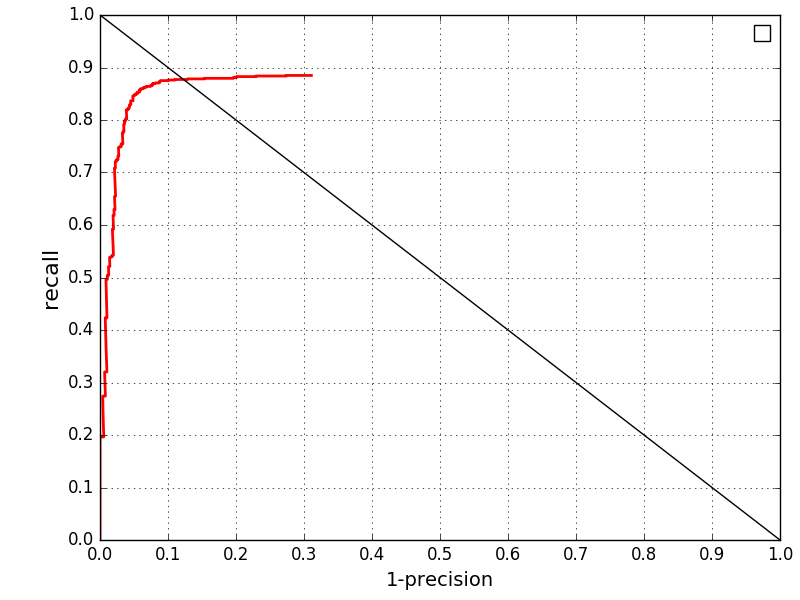

In [4]:
annolist.save(pred_idl)
iou_threshold = 0.5
rpc_cmd = './utils/annolist/doRPC.py --minOverlap %f %s %s' % (iou_threshold, true_idl, pred_idl)
print('$ %s' % rpc_cmd)
rpc_output = subprocess.check_output(rpc_cmd, shell=True)
print(rpc_output)
txt_file = [line for line in rpc_output.split('\n') if line.strip()][-1]
output_png = 'output/results.png'
plot_cmd = './utils/annolist/plotSimple.py %s --output %s' % (txt_file, output_png)
print('$ %s' % plot_cmd)
plot_output = subprocess.check_output(plot_cmd, shell=True)
from IPython.display import Image
Image(filename=output_png) 